In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# 文献中的反应截面

不使用 ENDF/B 核数据库的情况下，可以直接用文献里面的反应截面曲线。

先用工具（比如 [WebPlotDigitizer](https://apps.automeris.io/wpd/)）提取曲线里的点，再插值。

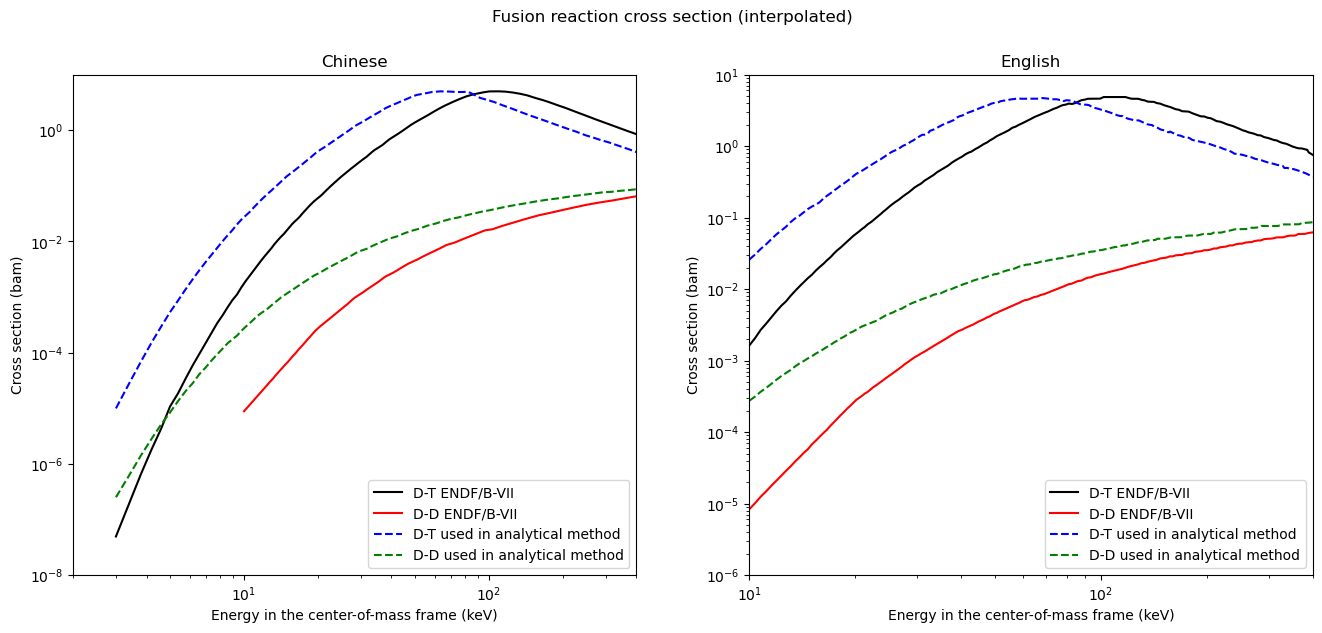

In [59]:
def interpolate_csv(path):
    # 读取csv文件
    xs_data = np.genfromtxt(path, delimiter=",", skip_header=True)
    # 插值数据点，得到一个插值函数
    return interpolate.interp1d(xs_data[:, 0], xs_data[:, 1])


# 绘制插值曲线
fig, axs = plt.subplots(1, 2, figsize=(16, 6.5))
fig.suptitle("Fusion reaction cross section (interpolated)")

# 中文论文图中x取值范围是[3, 400], 但是 D-D ENDF/B 的取值范围是[10, 400]。
x = np.linspace(3, 400, 1000)
x2 = np.linspace(10, 400, 1000)
axs[0].set_ylim((1e-8, 10))
axs[0].set_xlim((2, 400))
axs[0].set_xlabel("Energy in the center-of-mass frame (keV)")
axs[0].set_ylabel("Cross section (bam)")
axs[0].set_title("Chinese")

axs[0].plot(x, interpolate_csv("D-T ENDF.zh.csv")(x), label="D-T ENDF/B-VII", color="k")
axs[0].plot(
    x2, interpolate_csv("D-D ENDF.zh.csv")(x2), label="D-D ENDF/B-VII", color="r"
)
axs[0].plot(
    x,
    interpolate_csv("D-T analytical.zh.csv")(x),
    label="D-T used in analytical method",
    color="b",
    linestyle="--",
)
axs[0].plot(
    x,
    interpolate_csv("D-D analytical.zh.csv")(x),
    label="D-D used in analytical method",
    color="g",
    linestyle="--",
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].legend()

# 英文论文图中x取值范围是[10, 400]。
x = np.linspace(10, 400, 1000)
x2 = np.linspace(10, 400, 1000)
axs[1].set_ylim((1e-6, 10))
axs[1].set_xlim((10, 400))
axs[1].set_xlabel("Energy in the center-of-mass frame (keV)")
axs[1].set_ylabel("Cross section (bam)")
axs[1].set_title("English")

axs[1].plot(x, interpolate_csv("D-T ENDF.en.csv")(x), label="D-T ENDF/B-VII", color="k")
axs[1].plot(
    x2, interpolate_csv("D-D ENDF.en.csv")(x2), label="D-D ENDF/B-VII", color="r"
)
axs[1].plot(
    x,
    interpolate_csv("D-T analytical.en.csv")(x),
    label="D-T used in analytical method",
    color="b",
    linestyle="--",
)
axs[1].plot(
    x,
    interpolate_csv("D-D analytical.en.csv")(x),
    label="D-D used in analytical method",
    color="g",
    linestyle="--",
)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].legend()

# 论文中只使用了 20 keV 之后的数据，所以无论中文还是英文文献中的数据都是足够多的。
f_xs_DD = interpolate_csv("D-D ENDF.zh.csv")
f_xs_DT = interpolate_csv("D-T ENDF.zh.csv")

# 其他输入参数

粒子密度是 $10^{14} cm^{-3}$，换算成 $10^{20} m^{-3}$。

质量是我用中文文献中的“最概然速率”和那个动量公式反推出来的。

In [60]:
# Simulation input
n_i = 10**20  # m^{-3}, ion density
mass = {
    "D": 2 * 20000 / (1.9575 * 10**6) ** 2,
    "T": 2 * 20000 / (1.1325 * 10**6) ** 2,
}  # kg, mass of D and T
tau = 10 ** (-9)  # s, time step
h = 10 ** (-4)  # m, space grid size
n_samples = 10**5  # number of sampled mesh elements
grid = [100, 100, 100]  # dimensions of the grid
n_azim = 360  # number of azimuthal angles
n_polar = 180  # number of polar angles

# 随机速度

**采样入射粒子**：随机选择一个格子，再随机选择 D 或 T 中的一种粒子。

**采样速率**：给定能量 $kT$ 和粒子质量 $m$，从麦克斯韦速率分布中抽样。

**采样方向**：暂时从 360 个方位角和 180 个极角均匀抽取。

**采样速度**：用速率和方向计算出来。

后面我只用到了随机速度。

In [61]:
import random
import math
from scipy.stats import maxwell

class Particle:
    def __init__(self, t, x, y, z) -> None:
        self.type = t
        self.loc = np.array([x, y, z])

def random_particle(grid):
    """Return a random variable of particle.
    The return type of the random variable is Particle(type, x, y, z),
    in which the type is "D" for Deuterium or "T" for Tritium.
    """
    return lambda: Particle(random.choice(["D", "T"]),
                            random.randint(0, grid[0] - 1),
                            random.randint(0, grid[1] - 1),
                            random.randint(0, grid[2] - 1))


def random_speed(kT, m):
    """Return a random variable from the Maxwell-Boltzmann distribution.
    kT: energy, eV
    m: mass, kg
    a=\sqrt{kT/m}
    See https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution#Distribution_function
    """
    return lambda: maxwell.rvs(scale=math.sqrt(kT / m))


def random_direction(n_azim=360, n_polar=180):
    """Return a random variable of direction.
    n_azim: number of possible azimuthal angles in [0, 2\pi)
    n_polar: number of possible polar angles in [0, \pi/2)
    """
    azims = np.linspace(0, 2 * math.pi, n_azim)
    polars = np.linspace(0, 0.5 * math.pi, n_polar)
    return lambda: np.array([random.choice(azims), random.choice(polars)])


def random_velocity(kT, m, n_azim, n_polar):
    """Return a random variable of velocity.
    The velocity is calculated from a random speed and a random direction.
    kT: energy, eV
    m: mass, kg
    n_azim: number of possible azimuthal angles in [0, 2\pi)
    n_polar: number of possible polar angles in [0, \pi/2)
    """
    rv_speed = random_speed(kT, m)
    rv_direction = random_direction(n_azim, n_polar)

    def get_velocity(speed, direction):
        azim = direction[0]
        polar = direction[1]
        vx = speed * math.cos(polar) * math.cos(azim)
        vy = speed * math.cos(polar) * math.sin(azim)
        vz = speed * math.sin(polar)
        return np.array([vx, vy, vz])

    return lambda: get_velocity(rv_speed(), rv_direction())

Speed sampling test: 2702780.3638380286
Direction sampling test: [0.28003054 0.41244373]
Path: [-0.00012914 -0.00012307  0.00168778]


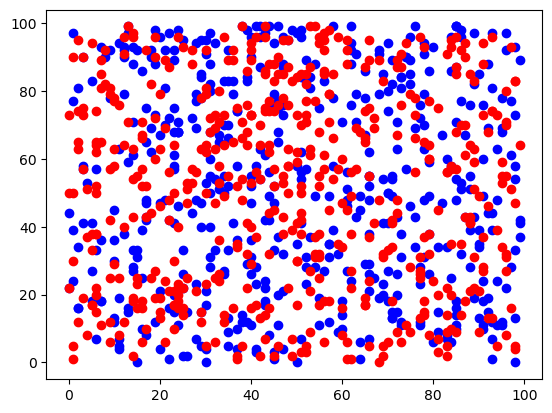

In [62]:
# 稍微测试一下
kT = 20000  # eV, temperature
rv_speed_D = random_speed(kT, mass["D"])
print(f"Speed sampling test: {rv_speed_D()}")
rv_direction = random_direction()
print(f"Direction sampling test: {rv_direction()}")
rv_velocity = random_velocity(kT, mass["D"], 360, 180)
print(f"Path: {rv_velocity() * tau}")

# 测试一下粒子采样
rv_particle = random_particle(grid)
particles = []
for i in range(1000):
    particles.append(rv_particle())

# 取出 D 和 T 两部分分别作图
Ds = np.array([[p.loc[0], p.loc[1]] for p in particles if p.type == "D"])
Ts = np.array([[p.loc[0], p.loc[1]] for p in particles if p.type == "T"])
plt.scatter(Ds[:, 0], Ds[:, 1], color="b")
plt.scatter(Ts[:, 0], Ts[:, 1], color="r")

# 质心系能量

假如质心系速度只是两个速度的加权平均，能量的计算如下。

In [63]:
def kT_center_of_mass(v_i, m_i, v_t, m_t):
    """Energy in a center of mass frame.
    v_i, m_i: velocity and mass of the incident particle
    v_t, m_t: velocity and mass of the target particle
    """
    m = m_i + m_t
    v_c = (v_i * m_i + v_t * m_t) / m
    return 0.5 * m * np.sum(v_c ** 2)

# 计算中子产生率反应率

## 解析公式结果

书上所说的解析公式为

$$
S\left(n_i, T_i\right)=n_i^2 \overline{\sigma v_{\mathrm{DT}}}\left(T_i\right)
$$

其中，
$$
\begin{aligned}
& \left\{\begin{array}{c}
\overline{\sigma v_{\mathrm{DT}}}\left(T_i\right)=\frac{C_1}{U^{\frac{5}{6}} T_i^{\frac{2}{3}}} \exp \left(-C_2\left(\frac{U}{T_i}\right)^{\frac{1}{3}}\right) \\
U=1-T_i \frac{C_3+T_i\left(C_4-C_5 T_i\right)}{1+T_i\left(C_6+C_7 T_i\right)}
\end{array},\right. \\
& C_1=2.5663271 \times 10^{-18} \\
& C_2=19.983026 \\
& C_3=2.5077133 \times 10^{-2} \\
& C_4=2.5773408 \times 10^{-3} \\
& C_5=6.1880463 \times 10^{-5} \\
& C_6=6.6024089 \times 10^{-2} \\
& C_7=8.1215505 \times 10^{-3} . \\
&
\end{aligned}
$$

Text(0, 0.5, 'Neutron source ($cm^{-3}s^{-1}$)')

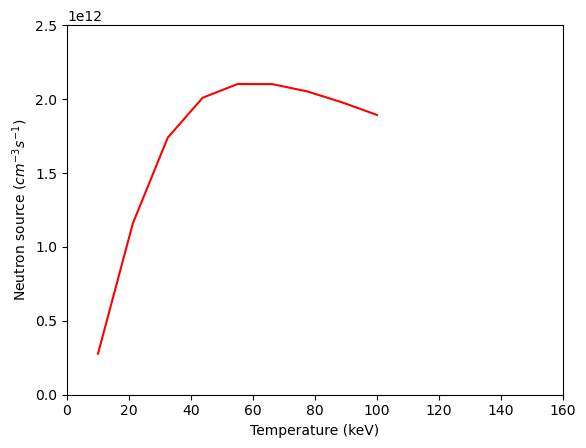

In [69]:
# Arguments
C_1 = 2.5663271 * 10 ** (-18)
C_2 = 19.983026
C_3 = 2.5077133 * 10 ** (-2)
C_4 = 2.5773408 * 10 ** (-3)
C_5 = 6.1880463 * 10 ** (-5)
C_6 = 6.6024089 * 10 ** (-2)
C_7 = 8.1215505 * 10 ** (-3)


def U(kT):
    return 1 - kT * (C_3 + kT * (C_4 - C_5 * kT)) / (1 + kT * (C_6 + C_7 * kT))


def σv(kT):
    U0 = U(kT)
    return C_1 / (U0 ** (5 / 6) * kT ** (2 / 3)) * math.exp(-C_2 * (U0 / kT) ** (1 / 3))


def S_a(n, kT):
    """Analytical S
    n: ion density, m^{-3}
    kT: energy, eV
    """
    return n**2 * σv(kT)


# 单位是 keV
kTs = np.linspace(10, 100, 9)
# 计算用的是国际单位，结果是 m^{-3}s^{-1}，换算成文献中用的 cm^{-3}s^{-1}。
analytical_rates = [S_a(0.5 * n_i, e) / 10**6 for e in kTs]

# 绘制曲线
plt.plot(kTs, analytical_rates, color="r")
plt.ylim([0, 2.5 * 10**12])
plt.xlim([0, 160])
plt.xlabel("Temperature (keV)")
plt.ylabel("Neutron source ($cm^{-3}s^{-1}$)")

## 根据中文文献计算（简化版）

试试看能不能算出和文献中差不多的中子产生率。

文献里有一个公式：
$$
S=n_i n_t \sigma' l/t
$$

我假设 $\sigma'$ 就是文献里用图给出来的截面，$l/t$ 就是随机的速率，看看能算出什么来。

为了找到合适的截面，还要确定是 D-D 或 D-T 中的哪一种反应，我让粒子完全按 1:1 的可能性选择之后决定是哪种反应。

### 结果

结果和文献的量级都是 $10^{12}\;cm^{-3}s^{-1}$，但是值更小。

图像趋势不一样。中文文献图 7 的结果只到 100 keV，看不出什么；英文文献 Fig. 4 的结果到 150 keV，转折点在 130 keV 附近。这里的计算结果转折点在 80 keV 到 100 keV 之间。

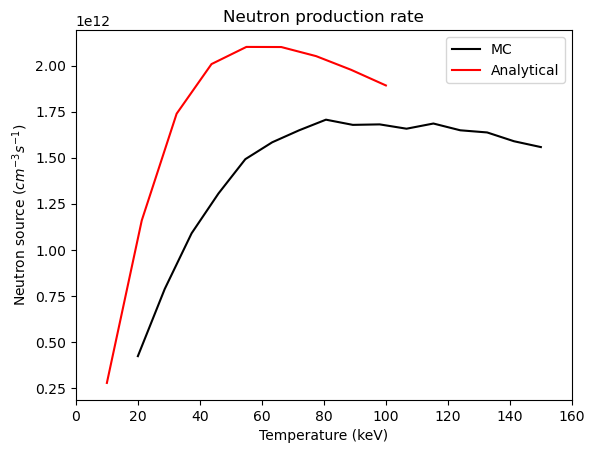

In [77]:
# 变量太多，大部分先用全局变量
def mc_neutron_rate_S(kT, n_ip, n_tp, n_samples):
    """Neutron production rate.
    kT: energy, eV
    n_ip: density of the incident particle, m^{-3}
    n_tp: density of the target particle, m^{-3}
    """
    xs_picker = {
        "DD": f_xs_DD,
        "DT": f_xs_DT,
        "TD": f_xs_DT,
    }
    rv_velocity = {"D": random_velocity(kT, mass["D"], n_azim, n_polar),
                   "T": random_velocity(kT, mass["T"], n_azim, n_polar)}

    rate_DT = 0.0

    for i in range(n_samples):
        p_i = random.choice(["D", "T"])

        # 入射为 T 时，直接选 D 作为靶子，提高反应率
        if p_i == "T":
            p_t = "D"
        else:
            p_t = random.choice(["D", "T"])

        xs = xs_picker[p_i + p_t]
        v_i = rv_velocity[p_i]()
        v_t = rv_velocity[p_t]()

        # 计算质心系能量，用上下限处理暂时没有的数据
        kT_c = kT_center_of_mass(v_i, mass[p_i], v_t, mass[p_t])
        kT_c = min(max(10000, kT_c), 400000)

        # 计算速率
        speed_i = np.sqrt(np.sum(v_i ** 2))

        # 按照 S 的公式计算反应率
        rate_DT += n_ip * n_tp * xs(kT_c / 1000) * 10 ** (-28) * speed_i

    return rate_DT / n_samples / 10**6  # cm^{-3}s^{-1}

# 用随机速率计算 S 的值
# 采样次数，论文用的 10^5，我电脑上跑着慢，改小了。
n_samples = 10**4

# 能量从 20keV 开始。前面的函数都用单位 eV，所以下面乘以 1000。
kTs = np.linspace(20, 150, 16)
mc_rates = [mc_neutron_rate_S(e * 1000, 0.5 * n_i, 0.5 * n_i, n_samples) for e in kTs]

# 解析公式结果，这个公式用的能量单位是 keV
kTs_a = np.linspace(10, 100, 9)
analytical_rates = [S_a(0.5 * n_i, e) / 10**6 for e in kTs_a]

# 绘制曲线
plt.plot(kTs, mc_rates, color="black", label="MC")
plt.plot(kTs_a, analytical_rates, color="red", label="Analytical")
plt.title("Neutron production rate")
plt.xlabel("Temperature (keV)")
plt.ylabel("Neutron source ($cm^{-3}s^{-1}$)")
plt.xlim([0, 160])
plt.legend()

## 根据英文文献计算（简化版）

按照英文文献的公式计算。公式为
$$
R=\Sigma\phi V
$$
其中，$R$ 是所求的核反应率，不过这个公式中它的单位是 $s^{-1}$，不是 $cm^{-3}s^{-1}$；$\Sigma$ 是 trace meshes 的宏观截面，等于密度乘以微观截面，$n_t\sigma$；$\phi$ 是入射粒子通量，文献说等于单个时间步内入射粒子的 trace length；$V$ 是 trace meshes 的体积。

按照这个说明，我下面就简单算一下。配置如下：
- 宏观截面就换成 $n_t\sigma$，$n_t=10^{20}\;m^{-3}$。
- $\sigma$ 就用从文献中提取的数据。
- $\phi$ 就用随机的速率乘以时间 $v\tau$，时间 $\tau=1\; ns$。
- $V$ 就用 trace meshes 数量乘以格子体积，数量就用 trace length 大概跨过的格子数估计一下。

### 结果

量级和文献差很多。这里的单位是 $s^{-1}$，而英文文献的图中的单位却是 $cm^{-3}s^{-1}$，可能是文献没写清楚。按照这个公式，不仅多乘了一个体积，还少乘了个密度，所以数值特别小。

少乘的密度在 $\phi=nv$ 里面，按照这个算法，$\phi=l=v\tau$，所以值很小。

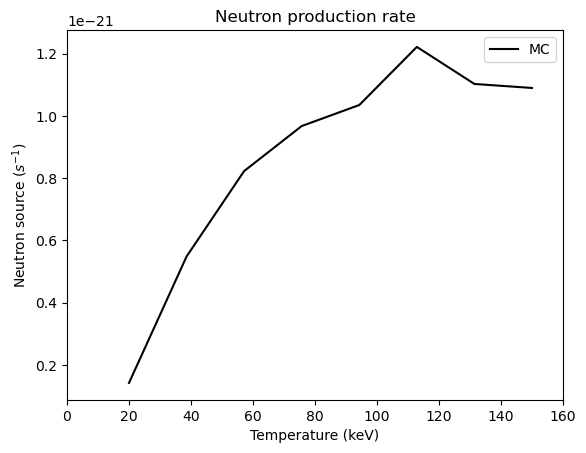

In [66]:
def mc_neutron_rate_R(kT, n, n_samples):
    """Neutron production rate, R
    kT: energy, eV
    n: target ion density, m^{-3}
    """
    rv_velocity = {"D": random_velocity(kT, mass["D"], n_azim, n_polar),
                   "T": random_velocity(kT, mass["T"], n_azim, n_polar)}
    xs_picker = {"DD": f_xs_DD,
                 "DT": f_xs_DT,
                 "TD": f_xs_DT}

    rate_DT = 0.0

    for i in range(n_samples):
        p_i = random.choice(["D", "T"])
        p_t = random.choice(["D", "T"])
        v_i = rv_velocity[p_i]()
        v_t = rv_velocity[p_t]()

        # 跳过 T-T 反应
        if p_i == "T" and p_t == "T":
            continue

        xs = xs_picker[p_i + p_t]

        # 跳过暂时没有的数据
        kT_c = kT_center_of_mass(v_i, mass[p_i], v_t, mass[p_t])
        if kT_c <= 10000 or kT_c >= 400000:
            continue

        speed = np.sqrt(np.sum(v_i ** 2))

        l = speed * tau
        V = l // h * h**3

        rate_DT += n * xs(kT_c / 1000) * 10**(-28) * l * V

    return rate_DT / n_samples  # s^{-1}


# 用随机速率计算 R 的值
# 采样次数，论文用的 10^5，我电脑上跑着慢，改小了。
n_samples = 10**3

# 能量从 20keV 开始。前面的函数都用单位 eV，所以下面乘以 1000。
kTs = np.linspace(20, 150, 8)
mc_rates = [mc_neutron_rate_R(e * 1000, 0.5 * n_i, n_samples) for e in kTs]

# 解析公式结果，这个公式用的能量单位是 keV
analytical_rates = [S_a(0.5 * n_i, e) / 10**6 for e in kTs]

# 绘制曲线
plt.plot(kTs, mc_rates, color="black", label="MC")
# plt.plot(kTs, analytical_rates, color="red", label="Analytical")
plt.title("Neutron production rate")
plt.xlabel("Temperature (keV)")
plt.ylabel("Neutron source ($s^{-1}$)")
plt.xlim([0, 160])
plt.legend()